In [48]:
import pandas as pd
import spacy
import pandas as pd
import numpy as np
from nltk.tokenize import sent_tokenize
from transformers import pipeline
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

In [49]:
nlp = spacy.load("en_core_web_lg")
skill_pattern_path = "jz_skill_patterns.jsonl"
ruler = nlp.add_pipe("entity_ruler")
ruler.from_disk(skill_pattern_path)
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler']

In [50]:
def get_skills(text):
    doc = nlp(text)
    myset = []
    subset = []
    for ent in doc.ents:
        if ent.label_ == "SKILL":
            subset.append(ent.text)
    myset.append(subset)
    return subset

def unique_skills(x):
    return list(set(x))

In [51]:
data = pd.read_csv('data.csv')
data.head(10)

,resume_text,job_description_text,label
0,SummaryHighly motivated Sales Associate with e...,Net2Source Inc. is an award-winning total work...,No Fit
1,Professional SummaryCurrently working with Cat...,At Salas OBrien we tell our clients that were ...,No Fit
2,SummaryI started my construction career in Jun...,Schweitzer Engineering Laboratories (SEL) Infr...,No Fit
3,SummaryCertified Electrical Foremanwith thirte...,"Mizick Miller & Company, Inc. is looking for a...",No Fit
4,SummaryWith extensive experience in business/r...,Life at Capgemini\nCapgemini supports all aspe...,No Fit
5,"SummarySolution-oriented, results-driven strat...",\n\nResponsibilitiesLead and provide day-to-da...,No Fit
6,SummaryA position in a company that will utili...,"Senior Salesforce Software Engineer, Salesforc...",No Fit
7,SummaryTo participate as a team member in a dy...,***W2 ONLY** \nSoftware Engineer (12-month con...,No Fit
8,SummaryMore than ten years of progressive expe...,Calling all innovators find your future at Fi...,No Fit
9,SummaryCERTIFIED SOFTWARE DEVELOPMENT PROFESSI...,Who We AreWere reinventing the egg protein bus...,No Fit


In [53]:
sample_no_fit = data[data['label'] == 'No Fit'].sample(n=10, random_state=1)
sample_potential_fit = data[data['label'] == 'Potential Fit'].sample(n=10, random_state=1)
sample_good_fit = data[data['label'] == 'Good Fit'].sample(n=10, random_state=1)

data = pd.concat([sample_no_fit, sample_good_fit, sample_potential_fit])
data.count()

resume_text             30
job_description_text    30
label                   30
dtype: int64

In [54]:
model = SentenceTransformer('all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [58]:
def calculate_similarity(job_description, resume, label):
    job_posting_skills = unique_skills(get_skills(job_description))
    job_posting_sentences = sent_tokenize(job_description)
    job_posting_sentences = job_posting_skills
    print(job_posting_sentences)

    resume_skills = unique_skills(get_skills(resume))
    resume_sentences = sent_tokenize(resume)
    resume_sentences = resume_skills
    print(resume_sentences)

    similarities = {}

    for job_posting_sentence in job_posting_sentences:
        max_similarity = float('-inf')
        for resume_sentence in resume_sentences:
            job_posting_vector = model.encode(job_posting_sentence).reshape(1, -1)
            resume_vector = model.encode(resume_sentence).reshape(1, -1)
            
            similarity = cosine_similarity(job_posting_vector, resume_vector)

            if similarity > max_similarity:
                similarities[job_posting_sentence] = np.squeeze(similarity[0])

    overall_similarity = sum(similarities.values())

    print(overall_similarity)
    print(label)

    return overall_similarity

tqdm.pandas()
data['similarity'] = data.progress_apply(lambda row: calculate_similarity(row['job_description_text'], row['resume_text'], row['label']), axis=1)

  0%|          | 0/30 [00:00<?, ?it/s]

['Kubernetes', 'SQL', 'data structures', 'Azure', 'computer science', 'NoSQL', 'business', 'airflow', 'algorithms', 'data warehouse', 'data management', 'support', 'Confluence', 'data science', 'analytics', 'engineering', 'Business', 'databases']
['Library', 'libraries', 'Server', 'Windows', 'security', 'monitoring', 'business', 'operating systems', 'operating system', 'software', 'documentation', 'schedule', 'database']


  7%|▋         | 2/30 [00:04<01:02,  2.24s/it]

7.375812888145447
No Fit
['medium', 'Support', 'business', 'Business', 'collaboration', 'documentation', 'business process', 'box', 'testing', 'Workflow', 'project management', 'workflow', 'release', 'database', 'support']
['Windows', 'business', 'software', 'Accounting', 'schedule', 'Software', 'accounting']


 10%|█         | 3/30 [00:06<00:58,  2.18s/it]

4.723508715629578
No Fit
['Accounting', 'schedule', 'project management', 'Monitoring', 'finance', 'accounting', 'support']
['business', 'payments', 'software', 'testing', 'Accounting', 'finance', 'accounting']


 13%|█▎        | 4/30 [00:07<00:44,  1.71s/it]

3.7688395380973816
No Fit
['business', 'accounting']
['Testing', 'medium', 'business', 'documentation', 'Medium', 'testing']


 17%|█▋        | 5/30 [00:07<00:30,  1.23s/it]

0.5196788311004639
No Fit
['Support', 'business', 'diagram', 'documentation', 'testing', 'project management', 'finance', 'Business', 'support']
['software engineering', 'design', 'Testing', 'syntax', 'databases', 'support', 'realm', 'documentation', 'data extraction', 'data integration', 'SQL', 'Azure', 'marketing', 'business', 'software', 'analytics', 'workflow', 'project management', 'database', 'data structures', 'data analysis', 'languages', 'performance monitoring', 'security', 'devise', 'testing', 'authentication', 'release']


 23%|██▎       | 7/30 [00:12<00:36,  1.57s/it]

2.8193820863962173
No Fit
['Testing', 'Python']
['database']
0.5228376686573029
No Fit
['design', 'engineering', 'databases', 'ambiguity', 'NoSQL', 'debugging', 'continuous integration', 'React', 'algorithms', 'REST API', 'continuous deployment', 'software', 'framework', 'JavaScript', 'data structures', 'Kubernetes', 'data center', 'security', 'operating systems', 'testing', 'authentication']
['design', 'medium', 'business', 'software', 'testing', 'schedule', 'project management', 'finance', 'Business', 'support']


 27%|██▋       | 8/30 [00:15<00:48,  2.21s/it]

4.420630171895027
No Fit
['data management', 'Azure']
['design', 'Analytics', 'Finance', 'engineering', 'Tableau', 'server', 'Software', 'PostGreSQL', 'SQL', 'Server', 'JIRA', 'business', 'mobile', 'analytics', 'Languages', 'database', 'commerce', 'XML', 'MySQL', 'Oracle']


 30%|███       | 9/30 [00:16<00:36,  1.76s/it]

0.5746589303016663
No Fit
['design', 'Design', 'C', 'documentation', 'Composer', 'Microprocessor', 'microprocessor']
['MATLAB', 'Design', 'Communications', 'Python', 'C', 'Engineering', 'Languages']


 33%|███▎      | 10/30 [00:17<00:29,  1.49s/it]

1.9282073676586151
No Fit
['software engineering', 'design', 'RabbitMQ', 'Design', 'JIRA', 'Databases', 'business', 'security', 'continuous integration', 'web app', 'software', 'algorithms', 'Framework', 'engineering', 'support']
['Testing', 'Windows', 'server', 'C', 'testing', 'Database', 'Payments', 'source code', 'Software', 'database']


 37%|███▋      | 11/30 [00:20<00:34,  1.83s/it]

4.992252871394157
No Fit
['syntax', 'data analysis', 'interaction', 'business', 'Accounting', 'schedule', 'play', 'accounting']
['marketing', 'business', 'C', 'documentation', 'accounting']


 40%|████      | 12/30 [00:20<00:27,  1.52s/it]

3.854761093854904
Good Fit
['business', 'schedule', 'accounting', 'flux']
['material', 'payments', 'documentation', 'Accounting', 'Finance', 'Monitoring', 'accounting']


 43%|████▎     | 13/30 [00:21<00:21,  1.24s/it]

2.0575861632823944
Good Fit
['software engineering', 'design', 'engineering', 'databases', 'support', 'continuous integration', 'collaboration', 'documentation', 'Software', 'MongoDB', 'medium', 'SQL', 'JIRA', 'computer science', 'business', 'continuous deployment', 'software', 'Kubernetes', 'Databases', 'eCommerce', 'testing', 'schedule', 'release', 'PostgreSQL']
['Testing', 'design', 'Java', 'Perl', 'support', 'Visual Studio', 'Windows', 'workload', 'Database', 'Software', 'linux', 'SQL', 'Server', 'business', 'monitoring', 'C', 'HTML', 'software', 'Languages', 'database', 'XML', 'Databases', 'COBOL', '.NET', 'testing', 'resource allocation', 'data warehouse', 'User Interface']


 47%|████▋     | 14/30 [00:32<01:07,  4.20s/it]

6.854781433939934
Good Fit
['Sonar', 'Release', 'computer science', 'business', 'security', 'software', 'Git', 'deployment', 'testing', 'compose', 'data visualization', 'Software', 'engineering', 'release', 'Confluence', 'databases']
['system testing', 'Testing', 'XML', 'design', 'SQL', 'business', 'certificate', 'C', 'C++', 'software', 'Commerce', 'Functional Testing', 'API', 'testing', 'Accounting', 'front end', 'release', 'Business']


 50%|█████     | 15/30 [00:37<01:05,  4.37s/it]

5.559832617640495
Good Fit
['business', 'component', 'finance', 'accounting', 'support']
['business', 'resource allocation', 'Languages', 'finance', 'database', 'support']


 53%|█████▎    | 16/30 [00:37<00:45,  3.23s/it]

2.2858894765377045
Good Fit
['design', 'framework', 'OpenGL', 'software']
['design', 'Android', 'jQuery', 'Rest API', 'HTML5', 'collaboration', 'Database', 'AJAX', 'Software', 'Support', 'SQL', 'Server', 'C', 'ASP.NET', 'HTML', 'software', 'DropBox', 'Commerce', 'mobile', 'API', 'library', 'database', 'CSS', 'REST Api', 'Business', 'data analysis', 'PHP', 'Databases', 'C++', 'iOS', '.NET', 'P2P', 'Objective C', 'PostgreSQL']


 57%|█████▋    | 17/30 [00:40<00:38,  2.99s/it]

0.9001429677009583
Good Fit
['design', 'Azure', 'business', 'software', 'business process', 'DevOps', 'testing', 'engineering', 'Business', 'support']
['design', 'Perl', 'Analytics', 'Computer Science', 'shell', 'Hadoop', 'engineering', 'databases', 'support', 'metadata', 'email marketing', 'domain knowledge', 'debugging', 'documentation', 'SQL', 'Server', 'business', 'monitoring', 'C', 'Metadata', 'data model', 'workflow', 'business intelligence', 'Business', 'data analysis', 'Databases', 'Business Intelligence', 'security', 'C++', 'Engineering', 'testing', 'data warehouse']


 57%|█████▋    | 17/30 [00:44<00:33,  2.61s/it]


KeyboardInterrupt: 

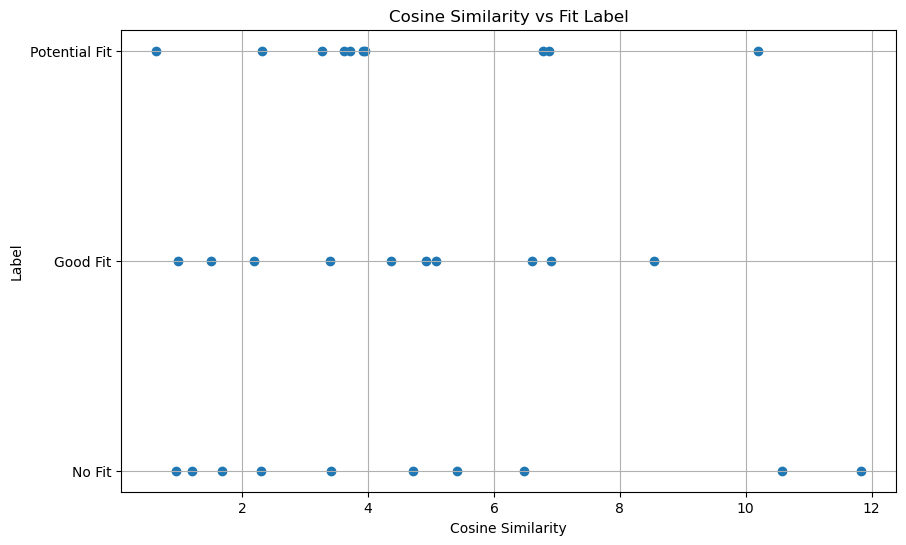

In [57]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(data['similarity'], data['label'])
plt.xlabel('Cosine Similarity')
plt.ylabel('Label')
plt.title('Cosine Similarity vs Fit Label')
plt.grid(True)
plt.show()